In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from numpy import *
from IPython.html.widgets import *
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Backpropagation Demo

In this demo, we will show a neural network that performs image classification.

First, load one of the face datasets:

In [7]:
import pickle

dataset = pickle.load(open('data/cafe.pkl','r')) # or 'pofa.pkl' 

In [8]:
# This is the neural network class, for your information.
from sklearn.decomposition import PCA
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split
from numpy.linalg import pinv
from numpy.random import random_sample

class NeuralNetwork(object):
    def __init__(self, dataset, target_name):
        self.dataset = dataset
        self.targets = self.dataset[target_name]
    
    def _activation(self, x):
        """ Funny tanh function. """
        z = x*2/3
        y = (exp(z) - exp(-z)) / (exp(z) + exp(-z))
        return 1.7159*y
    
    def _da(self, x):
        return (1.7159 - multiply(x, x) / 1.7159) * 2/3
    
    def _inverse_activation(self, x):
        z = x / 1.7159
        return z
        #z[z<-.999] = -.999; z[z>.999] = .999
        #return arctanh(z)*3/2
    
    def feed_forward(self, X):
        """From the input X, calculate the activations at the hidden layer and the output layer."""
        Z      = self._activation(dot(c_[X, ones((X.shape[0], 1))], self.W_hidden))
        return   self._activation(dot(c_[Z, ones((X.shape[0], 1))], self.W_output)), Z
                                        
    def back_propagate(self, inputs, hidden, output, errors):
        """Back-propagate the errors and update the weights."""
        d_output = self._da(output) * errors
        d_hidden = self._da(hidden) * dot(d_output, self.W_output[:-1].T)
        
        n_samples = inputs.shape[0]
        bias = ones((n_samples, 1))
        # Update momentum and weights
        self.V_output = self.output_learning_rate * dot(c_[hidden, bias].T, d_output) / n_samples
        self.W_output+= self.V_output
        
        self.V_hidden = self.hidden_learning_rate * dot(c_[inputs, bias].T, d_hidden) / n_samples
        self.W_hidden+= self.V_hidden 
    
    def train(self, epochs = 100, n_input = 10, n_hidden = 40, 
            hidden_learning_rate = 0.1, output_learning_rate = 0.1, momentum_learning_rate = 0.9,          
            test_size=0.2, cv=3):
        """Initialize the network and start training."""

        # Initialize variables
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.hidden_learning_rate = hidden_learning_rate
        self.output_learning_rate = output_learning_rate
        self.momentum_learning_rate = momentum_learning_rate
        
        self.n_output = len(unique(self.targets))
        self.V_hidden = zeros((self.n_input + 1, self.n_hidden))
        self.W_hidden = random_sample(self.V_hidden.shape)
        self.V_output = zeros((self.n_hidden + 1, self.n_output))
        self.W_output = random_sample(self.V_output.shape)
        
        data = self.dataset.data

        # Preprocess the data using PCA
        self.pca = PCA(n_components = self.n_input, whiten=True, copy=True)
        X = self.pca.fit_transform(data)
        self.X = X

        # Start the training
        rmse=zeros((epochs,2))
        cerr=zeros((epochs,2))
        for t in arange(epochs):
            
            # Test then Train, since we'll use the training errors
            for i, (inputs, y) in enumerate([[X_test, y_test], [X_train, y_train]]):
                outputs, hidden = self.feed_forward(inputs)
                target=ones(outputs.shape)*(-1.0)
                target[arange(target.shape[0]),y-1]=1.0
                errors = target - outputs
                rmse[t, i] = sqrt((errors**2).mean())  # RMSE
                cerr[t, i] = (y == argmax(outputs,axis=1)).mean()
            
            yield rmse, cerr, t, epochs
            
            # Update weights using backpropagation
            self.back_propagate(inputs, hidden, outputs, errors)

    def predict(self, n):
        """Returns the prediction and the reconstruction for the sample n."""
        X = self.X[n:n+1]
        outputs, hidden = self.feed_forward(X)
        pca_reconstruction = self.pca.inverse_transform(X)
        hidden_expected = dot(self._inverse_activation(outputs), pinv(self.W_output))[:,:-1]
        hidden_reconstruction = self.pca.inverse_transform(dot(self._inverse_activation(hidden_expected), pinv(self.W_hidden))[:,:-1])
        return (argmax(outputs) + 1,
                pca_reconstruction.reshape(self.dataset.images.shape[1:]),
                hidden_reconstruction.reshape(self.dataset.images.shape[1:]))

def plot_training(axs, rmse, cerr, t, epochs):
    """Draw the plot to the specified axis."""
    axs[0].set_title("RMSE")
    axs[0].set_xlabel("Training epoch")
    axs[0].set_ylabel("RMSE")
    axs[0].grid()

    axs[0].plot(arange(t), rmse[:t])
    axs[0].set_xlim([0, epochs])
    axs[0].set_ylim([0, 2.0])
    axs[0].legend(['Test', 'Training'], loc="best")

    axs[1].set_title("Classification Error")
    axs[1].set_xlabel("Training epoch")
    axs[1].set_ylabel("Classification Error Rate [\%]")
    axs[1].grid()

    axs[1].plot(arange(t), cerr[:t]*100.0)
    axs[1].set_xlim([0, epochs])
    axs[1].set_ylim([0, 100.0])
    axs[1].legend(['Test', 'Training'], loc="best")

def train_network(dataset, target_name, **kwargs):
    global net
    net = NeuralNetwork(dataset, target_name)
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    for rmse, cerr, t, epochs in net.train(**kwargs):
        if mod(t, 10) != 0:
            continue

        plot_training(axs, rmse, cerr, t, epochs)
        clear_output(wait=True)
        display(fig)
        axs[0].cla()
        axs[1].cla()

    plt.close()
    plot_training(axs, rmse, cerr, t, epochs)
    clear_output(wait=True)
    display(fig)

Then train the `net` using the controls here:

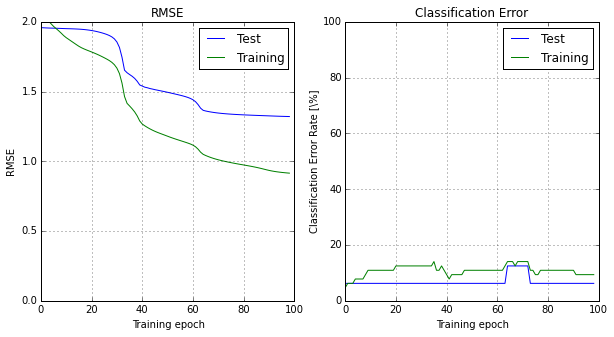

In [12]:
net = None # Global

interact_manual(train_network,
    dataset=fixed(dataset),
    target_name={'Identity': 'target', 'Gender': 'gender', 'Expression': 'expression'},
    epochs= IntSlider(min=10, max=500, step=10, value=100),
    n_input = IntSlider(min=1, max=(dataset.data.shape[0]-1), value=40),
    n_hidden = IntSlider(min=1, max=40, value=10), 
    hidden_learning_rate = FloatSlider(min=0.01, max=0.3, value=0.1),
    output_learning_rate = FloatSlider(min=0.01, max=0.3, value=0.1),
    momentum_learning_rate = FloatSlider(min=0.5, max=0.99, value=0.9),         
    test_size=FloatSlider(min=0.1, max=0.5, value=0.2))

After the network is trained, use it to classify test images.

In [10]:
@interact
def plot_classification(image_id=(0, dataset.images.shape[0]-1)):
    global net
    if net is None:
        print("Please train the network first!")
        return
    
    f, axs = plt.subplots(1,3, figsize=(10,5))
    axs[0].imshow(dataset.images[image_id],cmap='gray')
    axs[0].set_title('Id = %d, Target = %d' % (dataset.target[image_id], net.targets[image_id]))
    axs[0].axis('off')
    
    prediction, pca_r, hidden_r = net.predict(image_id)
    axs[1].imshow(pca_r,cmap='gray')
    axs[1].set_title('PCA reconstruction')
    axs[1].axis('off')

    axs[2].imshow(hidden_r,cmap='gray')
    axs[2].set_title('Reconstruction (predicted %d)' % prediction)
    axs[2].axis('off')

Please train the network first!


Let's plot the output node representation in 2D:

In [11]:
outputs, hidden = net.feed_forward(net.X)
model=PCA(n_components=2)
outputs_2d = model.fit_transform(outputs)
hidden_2d = model.fit_transform(hidden)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(hidden_2d[:,0],hidden_2d[:,1],c=net.targets,lw=0)
axs[0].set_title('Hidden Nodes')
axs[1].scatter(outputs_2d[:,0],outputs_2d[:,1],c=net.targets,lw=0)
axs[1].set_title('Output Nodes')

AttributeError: 'NoneType' object has no attribute 'feed_forward'